In [2]:
!pip install snowflake-connector-python pandas scikit-learn

In [3]:
import pandas as pd
import snowflake.connector

#step 1: connect to snowflake
conn = snowflake.connector.connect(
    user='YOUR_USERNAME',
    password='YOUR_PASSWORD',
    account='YOUR_ACCOUNT',
    database='BREAST_CANCER_DATASET', #DATABASE NAME
    schema='PUBLIC',
    warehouse='COMPUTE_WH' #WAREHOUSE NAME
)

In [6]:
#step 2: run query to fetch data
query = 'SELECT * FROM "MEDIDATA"' #TABLE NAME
df = pd.read_sql(query, conn)

#step 3: close connection
conn.close()

/tmp/ipython-input-1411041662.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


EDA

In [42]:
df.head()

,ID,DIAGNOSIS,RADIUS_MEAN,TEXTURE_MEAN,PERIMETER_MEAN,AREA_MEAN,SMOOTHNESS_MEAN,COMPACTNESS_MEAN,CONCAVITY_MEAN,CONCAVE_POINTS_MEAN,...,RADIUS_WORST,TEXTURE_WORST,PERIMETER_WORST,AREA_WORST,SMOOTHNESS_WORST,COMPACTNESS_WORST,CONCAVITY_WORST,CONCAVE_POINTS_WORST,SYMMETRY_WORST,FRACTAL_DIMENSION_WORST
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [43]:
df.tail()

,ID,DIAGNOSIS,RADIUS_MEAN,TEXTURE_MEAN,PERIMETER_MEAN,AREA_MEAN,SMOOTHNESS_MEAN,COMPACTNESS_MEAN,CONCAVITY_MEAN,CONCAVE_POINTS_MEAN,...,RADIUS_WORST,TEXTURE_WORST,PERIMETER_WORST,AREA_WORST,SMOOTHNESS_WORST,COMPACTNESS_WORST,CONCAVITY_WORST,CONCAVE_POINTS_WORST,SYMMETRY_WORST,FRACTAL_DIMENSION_WORST
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   DIAGNOSIS                569 non-null    int64  
 2   RADIUS_MEAN              569 non-null    float64
 3   TEXTURE_MEAN             569 non-null    float64
 4   PERIMETER_MEAN           569 non-null    float64
 5   AREA_MEAN                569 non-null    float64
 6   SMOOTHNESS_MEAN          569 non-null    float64
 7   COMPACTNESS_MEAN         569 non-null    float64
 8   CONCAVITY_MEAN           569 non-null    float64
 9   CONCAVE_POINTS_MEAN      569 non-null    float64
 10  SYMMETRY_MEAN            569 non-null    float64
 11  FRACTAL_DIMENSION_MEAN   569 non-null    float64
 12  RADIUS_SE                569 non-null    float64
 13  TEXTURE_SE               569 non-null    float64
 14  PERIMETER_SE             5

In [45]:
df.describe()

,ID,DIAGNOSIS,RADIUS_MEAN,TEXTURE_MEAN,PERIMETER_MEAN,AREA_MEAN,SMOOTHNESS_MEAN,COMPACTNESS_MEAN,CONCAVITY_MEAN,CONCAVE_POINTS_MEAN,...,RADIUS_WORST,TEXTURE_WORST,PERIMETER_WORST,AREA_WORST,SMOOTHNESS_WORST,COMPACTNESS_WORST,CONCAVITY_WORST,CONCAVE_POINTS_WORST,SYMMETRY_WORST,FRACTAL_DIMENSION_WORST
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [46]:
df.shape

(569, 32)

In [47]:
df.isnull().sum()

,0
ID,0
DIAGNOSIS,0
RADIUS_MEAN,0
TEXTURE_MEAN,0
PERIMETER_MEAN,0
AREA_MEAN,0
SMOOTHNESS_MEAN,0
COMPACTNESS_MEAN,0
CONCAVITY_MEAN,0
CONCAVE_POINTS_MEAN,0


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

naive bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
le = LabelEncoder()
df['DIAGNOSIS'] = le.fit_transform(df['DIAGNOSIS'])

In [51]:
X = df.drop(columns=['ID', 'DIAGNOSIS'])  # This is correct!
y = df['DIAGNOSIS']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
nb_model = GaussianNB()

In [55]:
nb_model.fit(X_train_scaled, y_train)

GaussianNB()

In [56]:
y_pred = nb_model.predict(X_test_scaled)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy:", accuracy)

Naive Bayes Accuracy: 0.9649122807017544


In [58]:
con_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix \n", con_matrix)

Confusion Matrix 
 [[70  1]
 [ 3 40]]


In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [60]:
import pickle
with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

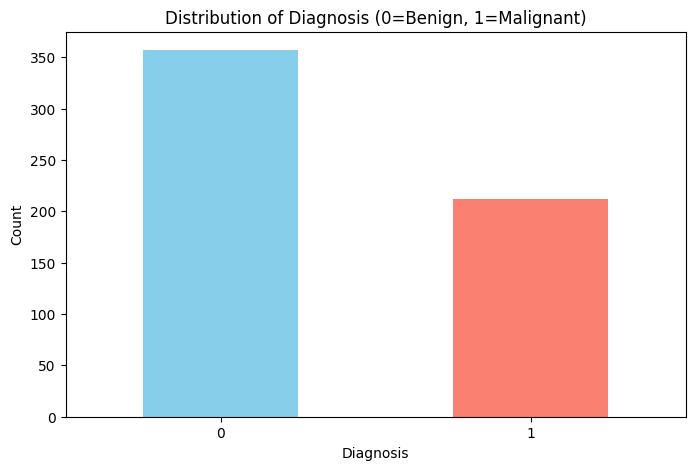

In [62]:
plt.figure(figsize=(8, 5))
df['DIAGNOSIS'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Diagnosis (0=Benign, 1=Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()




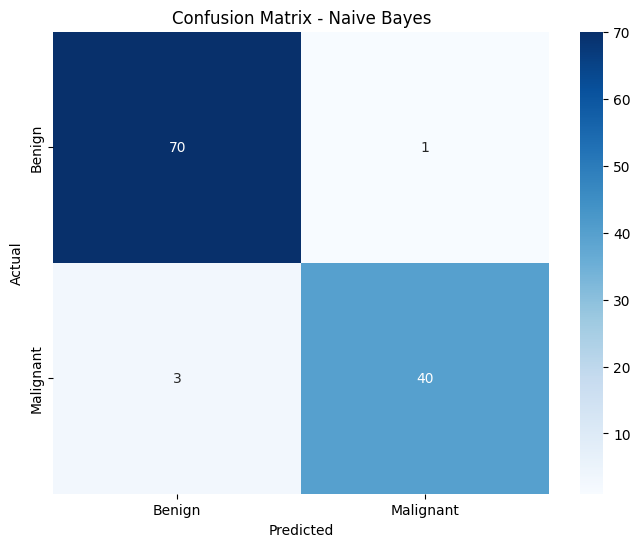

In [63]:
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [64]:
pip install gradio

In [65]:
import gradio as gr

def predict_cancer(radius_mean, texture_mean, perimeter_mean, area_mean,
                   compactness_mean, concavity_mean, concave_points_mean,
                   radius_worst, texture_worst, perimeter_worst, area_worst):

    try:
        features = np.array([[
            radius_mean,           # User input
            texture_mean,          # User input
            perimeter_mean,        # User input
            area_mean,             # User input
            0.096,                 # smoothness_mean (avg)
            compactness_mean,      # User input
            concavity_mean,        # User input
            concave_points_mean,   # User input
            0.181,                 # symmetry_mean (avg)
            0.063,                 # fractal_dimension_mean (avg)
            0.4,                   # radius_se (avg)
            1.2,                   # texture_se (avg)
            2.9,                   # perimeter_se (avg)
            40.0,                  # area_se (avg)
            0.007,                 # smoothness_se (avg)
            0.025,                 # compactness_se (avg)
            0.032,                 # concavity_se (avg)
            0.012,                 # concave_points_se (avg)
            0.020,                 # symmetry_se (avg)
            0.003,                 # fractal_dimension_se (avg)
            radius_worst,          # User input
            texture_worst,         # User input
            perimeter_worst,       # User input
            area_worst,            # User input
            0.132,                 # smoothness_worst (avg)
            0.254,                 # compactness_worst (avg)
            0.272,                 # concavity_worst (avg)
            0.115,                 # concave_points_worst (avg)
            0.290,                 # symmetry_worst (avg)
            0.084                  # fractal_dimension_worst (avg)
        ]])

        model = pickle.load(open('nb_model.pkl', 'rb'))
        scaler = pickle.load(open('scaler.pkl', 'rb'))

        features_scaled = scaler.transform(features)

        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0]

        if prediction == 0:
            result = "🟢 Benign"
            confidence = f"{probability[0]*100:.2f}%"
            message = "The tumor is predicted to be **benign** (non-cancerous)."
            color = "#10b981"
        else:
            result = "🔴 Malignant"
            confidence = f"{probability[1]*100:.2f}%"
            message = "The tumor is predicted to be **malignant** (cancerous). Please consult with a healthcare professional."
            color = "#ef4444"

        output_html = f"""
        <div style="padding: 30px; border-radius: 15px; background: linear-gradient(135deg, {color}15 0%, {color}05 100%); border: 2px solid {color}40;">
            <h2 style="color: {color}; margin: 0 0 15px 0; font-size: 28px;">{result}</h2>
            <p style="font-size: 16px; color: #374151; margin: 10px 0;">{message}</p>
            <p style="font-size: 20px; font-weight: 600; color: {color}; margin: 15px 0 0 0;">
                Confidence: {confidence}
            </p>
            <div style="margin-top: 15px; padding: 15px; background: white; border-radius: 8px;">
                <p style="margin: 0; color: #6b7280; font-size: 14px;">
                    <strong>Benign probability:</strong> {probability[0]*100:.2f}% |
                    <strong>Malignant probability:</strong> {probability[1]*100:.2f}%
                </p>
            </div>
        </div>
        """

        return output_html

    except Exception as e:
        return f"""
        <div style="padding: 20px; border-radius: 10px; background: #fee2e2; border: 2px solid #ef4444;">
            <p style="color: #991b1b; margin: 0;">⚠️ Error: {str(e)}</p>
        </div>
        """

# CSS
custom_css = """
.gradio-container {
    font-family: 'Inter', sans-serif;
    max-width: 900px;
    margin: 0 auto;
}

h1 {
    text-align: center;
    color: #1f2937;
    font-size: 2.5em;
    margin-bottom: 10px;
    font-weight: 700;
}

.subtitle {
    text-align: center;
    color: #6b7280;
    font-size: 1.1em;
    margin-bottom: 30px;
}

footer {
    display: none !important;
}
"""

# Create Gradio interface
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as app:

    gr.HTML("""
        <div style="text-align: center; margin-bottom: 30px;">
            <h1>🔬 Breast Cancer Prediction</h1>
            <p class="subtitle">Enter the most important cell nucleus measurements</p>
        </div>
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 📊 Mean Measurements")
            radius_mean = gr.Number(label="Radius Mean", value=14.0,
                                   info="Average radius of cell nuclei")
            texture_mean = gr.Number(label="Texture Mean", value=19.0,
                                    info="Standard deviation of gray-scale values")
            perimeter_mean = gr.Number(label="Perimeter Mean", value=92.0,
                                      info="Average perimeter of nuclei")
            area_mean = gr.Number(label="Area Mean", value=655.0,
                                 info="Average area of nuclei")
            compactness_mean = gr.Number(label="Compactness Mean", value=0.104,
                                        info="Perimeter² / area - 1.0")
            concavity_mean = gr.Number(label="Concavity Mean", value=0.089,
                                      info="Severity of concave portions")
            concave_points_mean = gr.Number(label="Concave Points Mean", value=0.049,
                                           info="Number of concave portions")

        with gr.Column():
            gr.Markdown("### 🔺 Worst Measurements")
            radius_worst = gr.Number(label="Radius Worst", value=16.3,
                                    info="Largest radius value")
            texture_worst = gr.Number(label="Texture Worst", value=25.7,
                                     info="Largest texture value")
            perimeter_worst = gr.Number(label="Perimeter Worst", value=107.0,
                                       info="Largest perimeter value")
            area_worst = gr.Number(label="Area Worst", value=880.0,
                                  info="Largest area value")

    predict_btn = gr.Button("🔍 Predict Diagnosis", variant="primary", size="lg")

    output = gr.HTML(label="Prediction Result")

    predict_btn.click(
        fn=predict_cancer,
        inputs=[
            radius_mean, texture_mean, perimeter_mean, area_mean,
            compactness_mean, concavity_mean, concave_points_mean,
            radius_worst, texture_worst, perimeter_worst, area_worst
        ],
        outputs=output
    )

    gr.HTML("""
        <div style="text-align: center; margin-top: 30px; padding: 20px; background: #f3f4f6; border-radius: 10px;">
            <p style="color: #6b7280; font-size: 0.9em; margin: 0;">
                ⚕️ <strong>Disclaimer:</strong> This is an AI prediction tool for educational purposes only.
                Always consult with qualified healthcare professionals for medical diagnosis and treatment.
            </p>
        </div>
    """)

# Launch the app
if __name__ == "__main__":
    app.launch(share=True)

/tmp/ipython-input-3742432468.py:118: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as app:
/tmp/ipython-input-3742432468.py:118: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as app:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58936fc3d092ae9c3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
